In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]
interval = "1h"

fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

beta_hedge = True
is_spread = False

### 1. Training

In [3]:
pair_selection_start = "2024-01-01"
pair_selection_end = "2024-03-01"

#### 1.1 Pair Selection

In [4]:
# Load data
from modules.data_services.data_loaders import load_data

df = load_data(
    tickers=tickers,
    start=pair_selection_start,
    end=pair_selection_end,
    interval=interval
)

In [5]:
# Pair Selection
from modules.pair_selection.statistical_tests import engle_granger_cointegration

eg_df = engle_granger_cointegration(df)
eg_df.head(5)

,pair,eg_p_value,adf_stat
0,ETHUSDT-BCHUSDT,0.002988,-4.256718
1,BTCUSDT-BCHUSDT,0.004171,-4.161398
2,BNBUSDT-UNIUSDT,0.007593,-3.982967
3,BTCUSDT-ADAUSDT,0.013955,-3.790522
4,BTCUSDT-SOLUSDT,0.015325,-3.759751


In [6]:
# Select a TOP1 pair
tickers = eg_df.iloc[0:1, 0].tolist()
ticker_x = tickers[0].split('-')[0]
ticker_y = tickers[0].split('-')[1]

#### 1.2 Parameter optimization

In [7]:
pre_training_start = "2024-01-01"
training_start = "2024-02-01"
training_end = "2024-03-01"

In [8]:
# Perform Bayesian Optimization
from skopt.space import Integer, Real
from modules.performance.strategy import optimize_params

param_space = [
    Integer(10, 30, name="rolling_window"),
    Real(2.0, 2.5, name="entry_threshold"),
    Real(0.5, 1.0, name="exit_threshold"),
    Real(2.0, 3.0, name="stop_loss"),
]
metric = ("sortino_ratio_annual", "0.05% fee")

best_params, best_score = optimize_params(ticker_x, ticker_y, fee_rate, initial_cash, position_size, pre_training_start,
                                          training_start, training_end, interval, beta_hedge, is_spread, param_space,
                                          metric)

print(best_params)
print(best_score)

{'rolling_window': 15, 'entry_threshold': 2.1210531256735474, 'exit_threshold': 0.5869149827356068, 'stop_loss': 2.8396273007810224}
3.901


### 2. Test

In [9]:
pre_test_start = "2024-02-01"
test_start = "2024-03-01"
test_end = "2024-04-01"

In [10]:
# Load pair and calculate returns
from modules.data_services.data_loaders import load_pair
from modules.data_services.data_utils import add_returns

pair = load_pair(x=ticker_x, y=ticker_y, start=pre_test_start, end=test_end, interval=interval)
add_returns(pair)

In [11]:
entry_threshold = best_params["entry_threshold"]
exit_threshold = best_params["exit_threshold"]
stop_loss = best_params["stop_loss"]
rolling_window = best_params["rolling_window"]

In [12]:
# Run strategy
from modules.performance.strategy import single_pair_strategy

pair.test_start = test_start
pair.fee_rate = fee_rate
pair.initial_cash = initial_cash

single_pair_strategy(pair, rolling_window, entry_threshold, exit_threshold, stop_loss, position_size, beta_hedge,
                     is_spread)
pair.data.drop(columns=['total_return', 'total_fees', 'net_return'])

,ETHUSDT,BCHUSDT,z_score,beta,entry_thr,exit_thr,sl_thr,w_x,w_y,q_x,q_y,position,total_return_pct,net_return_pct
open_time,,,,,,,,,,,,,,
2024-03-01 00:00:00,3378.73,304.2,-0.6378,0.5932,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.0000,0.0000
2024-03-01 01:00:00,3375.20,306.1,-0.6225,0.5813,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.0000,0.0000
2024-03-01 02:00:00,3366.73,313.5,-0.7437,0.4785,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.0000,0.0000
2024-03-01 03:00:00,3367.79,317.5,-0.6463,0.4381,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.0000,0.0000
2024-03-01 04:00:00,3376.87,315.1,-0.3182,0.4061,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 20:00:00,3633.25,680.5,1.2185,0.0155,2.1211,0.5869,8.527453,0.844333,0.155667,-23.4264,26.053,-1.0,0.1718,0.1403
2024-03-31 21:00:00,3625.32,678.8,0.2888,0.0267,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.1741,0.1421
2024-03-31 22:00:00,3629.80,680.8,0.7179,0.0290,2.1211,0.5869,None,None,None,0.0000,0.000,0.0,0.1741,0.1421


In [13]:
# Calculate statistics
from modules.performance.strategy import calculate_stats

pair.stats = calculate_stats(pair)
pair.stats

,0% fee,0.05% fee
metric,,
total_return,0.1741,0.1421
cagr,5.6025,3.7674
volatility,0.0047,0.0047
volatility_annual,0.4394,0.4425
max_drawdown,-0.0560,-0.0562
win_count,21.0000,21.0000
lose_count,11.0000,11.0000
win_rate,0.6562,0.6562
max_win,0.0595,0.0590


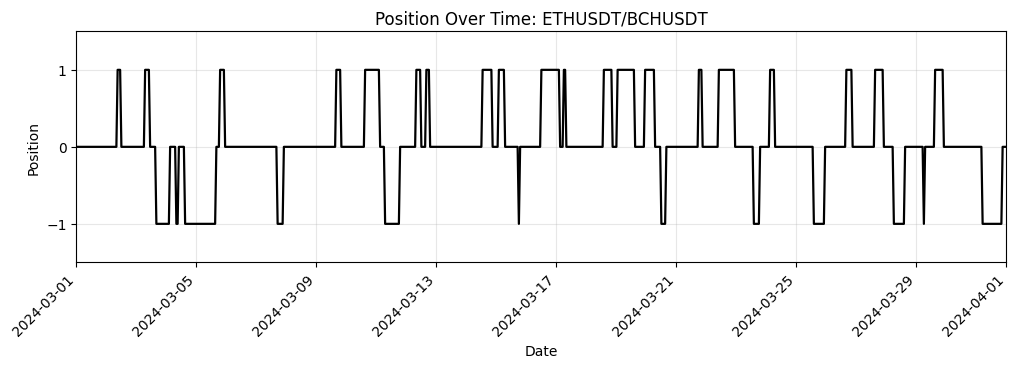

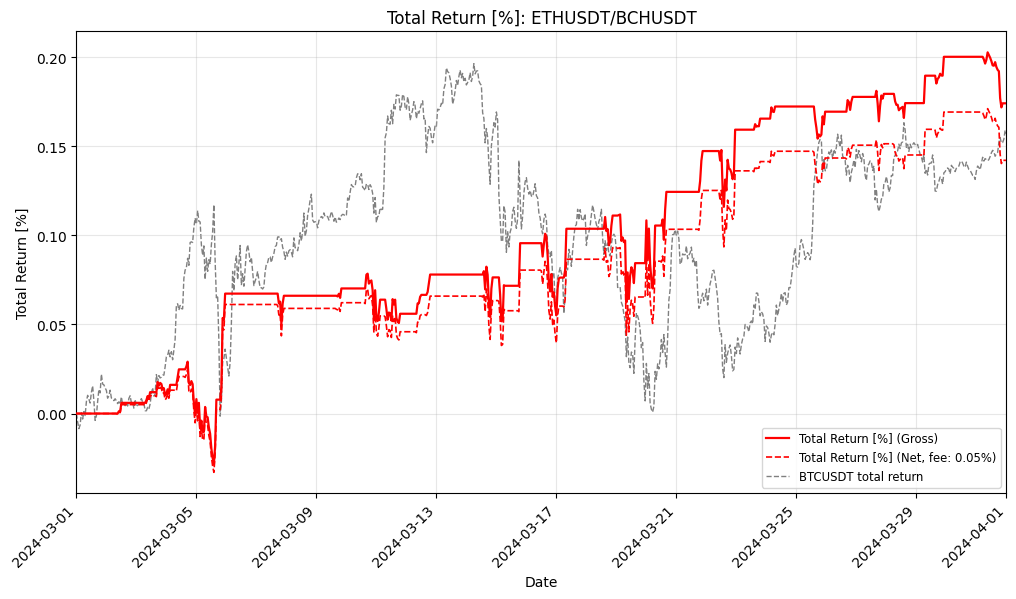

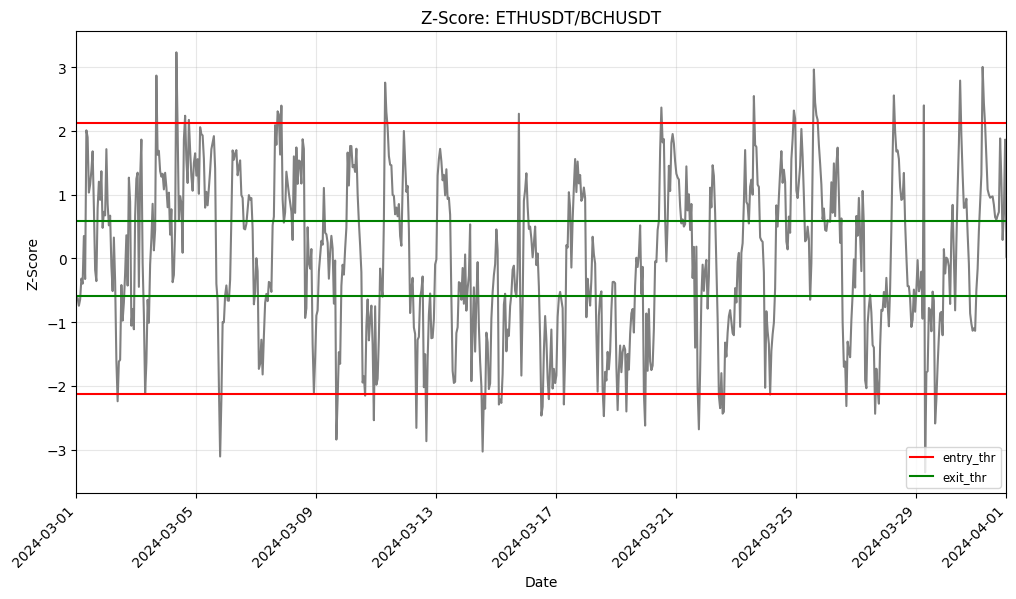

In [14]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions, plot_zscore

plot_positions(pair, 'strategy', False, True)

btc_data = load_data(
    tickers=['BTCUSDT'],
    start=test_start,
    end=test_end,
    interval=interval,
)
btc_data['BTC_return'] = btc_data['BTCUSDT'].pct_change()
btc_data.loc[btc_data.index[0], 'BTC_return'] = 0.0
btc_data['BTC_cum_return'] = (1 + btc_data['BTC_return']).cumprod() - 1

plot_pnl(pair, btc_data, 'strategy', False, True)
plot_zscore(pair)